In [158]:
import numpy as np 
import pandas as pd 
from IPython.display import HTML
import base64
import matplotlib.pyplot as plt
import seaborn as sns
import json
from plots.matplot_imgs  import * 

### Funcao cria link para imprimir dataframe

In [159]:
def create_download_link(df, title = "Download CSV file", filename = "data_atualizada.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [160]:
total_column_names = ['Tipo', 'Bairro', 'Dormitorios', 'Banheiros', 'Garagens', 'A. Terreno M²', 'A. Construída M²', 'Alarme', 'ArCondicionado', 'Armarios', 'BoxBlindex', 'CercaEletrica', 'Churrasqueira', 'Cozinha', 'Escritorio', 'HomeTheater', 'Iluminacao', 'Lavabo', 'Piscina', 'Porcelanato', 'PortaoEletronico', 'SalaEstar', 'SalaJantar', 'SemiMobiliado', 'Varanda', 'Precio']

data = pd.read_csv('C:/Users/gaboh/UTFPR/GitHub/Toledo-Regression-Housing-predictor-IC/data_17-08-2023 - Hoja 2.csv', header = None, delimiter = ',', names = total_column_names)
data = data.iloc[1:]  # Drop the first row
print(data.head(5))
print(np.shape(data))

                 Tipo           Bairro Dormitorios Banheiros Garagens  \
1         Casa Padrão  Jardim Panorama           1         2      NaN   
2  Apartamento Padrão           Centro           1         3        2   
3  Apartamento Padrão    São Francisco           1         2      NaN   
4         Casa Padrão  Jardim Coopagro           2         2        2   
5         Casa Padrão    São Francisco           1         2        2   

  A. Terreno M² A. Construída M² Alarme ArCondicionado Armarios  ...  \
1       125.00            50.00       0              0        0  ...   
2       165.83           127.00       0              0        1  ...   
3        52.94            47.69       0              0        0  ...   
4       250.00           120.00       0              0        0  ...   
5       125.00            61.00       0              0        0  ...   

  Iluminacao Lavabo Piscina Porcelanato PortaoEletronico SalaEstar SalaJantar  \
1          1      0       0           0        

In [161]:
# Reemplazar "M²" por cadena vacía en las columnas numéricas
numeric_columns = ['Dormitorios', 'Banheiros', 'Garagens', 'A. Terreno M²', 'A. Construída M²', 'Precio']
data[numeric_columns] = data[numeric_columns].replace('M²', '', regex=True)

# Convertir las características a valores numéricos, reemplazando valores inválidos por 0
numeric_features = ['Dormitorios', 'Banheiros', 'Garagens', 'A. Terreno M²', 'A. Construída M²', 'Alarme', 'ArCondicionado',
                    'Armarios', 'BoxBlindex', 'CercaEletrica', 'Churrasqueira', 'Cozinha', 'Escritorio',
                    'HomeTheater', 'Iluminacao', 'Lavabo', 'Piscina', 'Porcelanato', 'PortaoEletronico',
                    'SalaEstar', 'SalaJantar', 'SemiMobiliado', 'Varanda', 'Precio']

data[numeric_columns] = data[numeric_columns].replace(' Alqueires Paulista', '', regex=True)
data[numeric_columns] = data[numeric_columns].replace('Consulte-nos', '', regex=True)


# Tratamento de Nan's 
* Subtituimos os 0 da area para poder aproximar um valor 

In [162]:
# Replace NaNs with a new value
data['A. Terreno M²'].replace('0', np.nan,  inplace=True)
data['A. Construída M²'].replace('0', np.nan, inplace=True)

# Reemplazar espacios vacíos por NaN
data.replace('', np.nan, inplace=True)
# Convertir las columnas a float64
data[numeric_features] = data[numeric_features].astype('float64')

#quantidade de  Nans
data.isna().sum()

Tipo                  0
Bairro                0
Dormitorios          17
Banheiros            54
Garagens            363
A. Terreno M²       364
A. Construída M²    661
Alarme                0
ArCondicionado        0
Armarios              0
BoxBlindex            0
CercaEletrica         0
Churrasqueira         0
Cozinha               0
Escritorio            0
HomeTheater           0
Iluminacao            0
Lavabo                0
Piscina               0
Porcelanato           0
PortaoEletronico      0
SalaEstar             0
SalaJantar            0
SemiMobiliado         0
Varanda               0
Precio                0
dtype: int64

## **Encoder** 
* Para categorical features cria um valor numerico para nome dentro do conjunto
*  label encoding, we might confuse our model into thinking that a column has data with some kind of order or hierarchy, when we clearly don’t have it. To avoid this, we ‘OneHotEncode’ that column.

In [163]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ['Tipo', 'Bairro']

encoder = OneHotEncoder(sparse=False)

# Ajustar y transformar las columnas categóricas
encoded_categorical_data = encoder.fit_transform(data[categorical_columns])
feature_labels = encoder.get_feature_names_out(input_features=categorical_columns)

encoded_df = pd.DataFrame(encoded_categorical_data, columns=feature_labels)
data.drop(columns = categorical_columns, inplace=True)

# Reset index data
data.reset_index(drop=True, inplace=True)

# concatenar 2 datasets 
for column in encoded_df.columns:
    data[column] = encoded_df[column]

print(np.shape(data))
print(data.isna().sum())

(2058, 96)
Dormitorios                     17
Banheiros                       54
Garagens                       363
A. Terreno M²                  364
A. Construída M²               661
                              ... 
Bairro_Vila Operária             0
Bairro_Vila Paulista             0
Bairro_Vila Pioneiro             0
Bairro_Zona Rural                0
Bairro_Área Rural de Toledo      0
Length: 96, dtype: int64


c:\Users\gaboh\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# TRAIN TESTE
* Dividimos o preco entre as amostras que nao tem valores vazios, pegamos a proporcao 85-15

In [164]:
from sklearn.model_selection import train_test_split

data_aux = data.dropna()
print(np.shape(data_aux))
train_data, test_data = train_test_split(data_aux, test_size=0.40, random_state=48)
print(np.shape(test_data))

(775, 96)
(310, 96)


In [165]:
# Filtrar data eliminando las filas con índices presentes en test_data
X_train_data = data.drop(index = test_data.index)

# Imprimir las formas de los DataFrames resultantes
print( np.shape(X_train_data))
print( np.shape(test_data))

(1748, 96)
(310, 96)


## Imputer (prencher espaços NULL)
#### **Vamos a importar IterativeImputer de forma multivariado para conseguir prencheer os dados faltantes usando regresoes e auto-ajustes **

In [166]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

null_column_names_imputer = ['Dormitorios', 'Banheiros', 'Garagens', 'A. Terreno M²', 'A. Construída M²' ]
# initial_strategy{‘mean’, ‘median’, ‘most_frequent’, ‘constant’}, default=’mean’
# imputation_order{‘ascending’, ‘descending’, ‘roman’, ‘arabic’, ‘random’}, default=’ascending’

imputer = IterativeImputer(
    initial_strategy='most_frequent',
    estimator=RandomForestRegressor(),
    imputation_order='ascending'
)
X_train_data[null_column_names_imputer] = imputer.fit_transform(X_train_data[null_column_names_imputer])

# Crear un DataFrame con las columnas imputadas
aux = pd.DataFrame(X_train_data[null_column_names_imputer], columns=null_column_names_imputer)

# Eliminar las columnas originales de Tipo y Bairro del DataFrame original
X_train_data = X_train_data.drop(columns=null_column_names_imputer)

# Concatenar el DataFrame original con las características imputadas en 'aux'
data_filled_nan_content = X_train_data.join(aux)

#resultado
print(data_filled_nan_content.isna().sum())
print(np.shape(data_filled_nan_content))
print("Número de valores negativos:", (data_filled_nan_content < 0).sum().sum())

Alarme              0
ArCondicionado      0
Armarios            0
BoxBlindex          0
CercaEletrica       0
                   ..
Dormitorios         0
Banheiros           0
Garagens            0
A. Terreno M²       0
A. Construída M²    0
Length: 96, dtype: int64
(1748, 96)
Número de valores negativos: 0


****
## **Descricao general do DataFrame**
* Verficacao do tipo de variaveis, quantidade de Null e descricao de cada feature ( mean , min, % , etc)

In [167]:
print("Descripción general del DataFrame:")
print(data_filled_nan_content.info())
print(data_filled_nan_content[null_column_names_imputer].describe())

Descripción general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1748 entries, 0 to 2057
Data columns (total 96 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Alarme                                  1748 non-null   float64
 1   ArCondicionado                          1748 non-null   float64
 2   Armarios                                1748 non-null   float64
 3   BoxBlindex                              1748 non-null   float64
 4   CercaEletrica                           1748 non-null   float64
 5   Churrasqueira                           1748 non-null   float64
 6   Cozinha                                 1748 non-null   float64
 7   Escritorio                              1748 non-null   float64
 8   HomeTheater                             1748 non-null   float64
 9   Iluminacao                              1748 non-null   float64
 10  Lavabo                   

# **Queremos analizar a quantidade de features e a corelacao entre elas**
* Podemos observar que Dormitorios Banheiros Garagens sao altamente relacionados

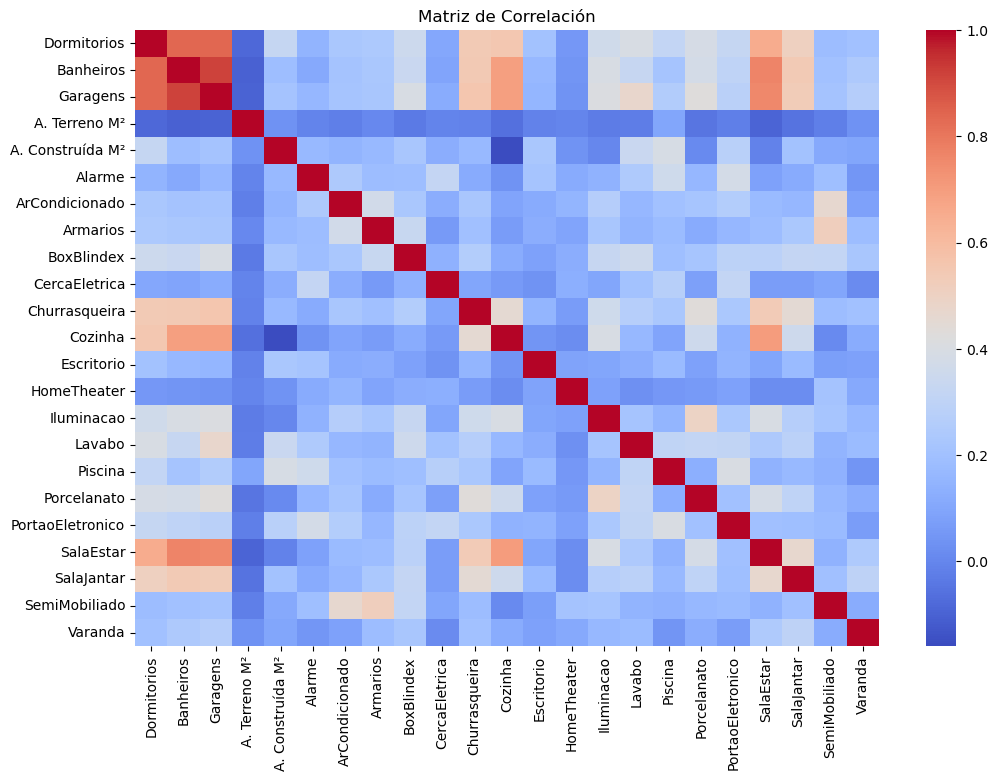

In [168]:
# Filtrar solo las columnas numéricas
numeric_columns = ['Dormitorios', 'Banheiros', 'Garagens', 'A. Terreno M²', 'A. Construída M²', 'Alarme', 'ArCondicionado',
                    'Armarios', 'BoxBlindex', 'CercaEletrica', 'Churrasqueira', 'Cozinha', 'Escritorio',
                    'HomeTheater', 'Iluminacao', 'Lavabo', 'Piscina', 'Porcelanato', 'PortaoEletronico',
                    'SalaEstar', 'SalaJantar', 'SemiMobiliado', 'Varanda']

# Crear un subconjunto con las columnas numéricas
numeric_data = data_filled_nan_content[numeric_columns]

coMatrix(numeric_data)

In [169]:
# plot stats para features
#plotFeatures(data_filled_nan_content, numeric_columns)

# Imprimir csv atualizado 

In [170]:
def create_download_link(df, title = "Download CSV file", filename = "data_atualizada.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

df_formatted = data_filled_nan_content.round(2)
create_download_link(df_formatted)

## Outliers
* Vamos tentar detetar e drop de outliers das principais features do nosso dataset 

In [171]:
# Box plot para identificar outliers 
#boxplot(data_filled_nan_content, null_column_names_imputer)

- A partir dos graficos, definimos constantes como criterios para defirmos outliers

In [172]:
outlier_criteria = {
                    'Banheiros': 6,    
                    'Garagens': 5, 
                    }

# Filtrar el DataFrame para eliminar filas con outliers
for column, threshold in outlier_criteria.items():
    data_ready = data_filled_nan_content[data_filled_nan_content[column] <= threshold]

print(np.shape(data_ready)) 

(1745, 96)


## Normizando os dados

In [173]:
from sklearn.preprocessing import MinMaxScaler

# Obtener una lista de los nombres de las columnas en tus datos
aux = data_ready.columns.tolist()

# Realizar la normalización min-max en train_data_ready
scaler = MinMaxScaler()
train_data_ready = data_ready.copy()
train_data_ready[aux] = scaler.fit_transform(train_data_ready[aux])

# Realizar la normalización min-max en test_data_ready
test_data_ready = test_data.copy()
test_data_ready[aux] = scaler.transform(test_data_ready[aux])

print(np.shape(train_data_ready))
print(np.shape(test_data_ready))

#boxplot(train_data_ready, null_column_names_imputer)


(1745, 96)
(310, 96)


In [174]:
print(train_data_ready['Precio'].describe())
print(test_data_ready['Precio'].describe())

count    1745.000000
mean        0.024561
std         0.043613
min         0.000000
25%         0.010552
50%         0.015898
75%         0.024976
max         1.000000
Name: Precio, dtype: float64
count    310.000000
mean       0.030606
std        0.024906
min        0.000025
25%        0.014975
50%        0.022476
75%        0.034591
max        0.161517
Name: Precio, dtype: float64


## Predicting MODELS


> Output = Precios
* extraimos o preco para usar-lo como target

In [175]:
#extraimos a coluna precio do dataset de treinamento 
train_target_precio = train_data_ready['Precio'] 
train_data_ready = train_data_ready.drop('Precio', axis=1) 

#extraimos a coluna precio do dataset de teste 
test_target_precio = test_data_ready['Precio'] 
test_data = test_data_ready.drop('Precio', axis=1) 


In [176]:
# Ordenar las columnas en el mismo orden
column_order = train_data_ready.columns

train_data_ready = train_data_ready[column_order]
test_data = test_data[column_order]

****
# Implementação Modelos

In [177]:
from Models.GradientBoostingRegressor  import *
from Models.LinearRegression import *
from Models.SVM import * 
from Models.XGBRegressor import *
from Models.HistGradientBoostingRegressor import *

In [178]:
# x_test -> test_data -> df 15%
# y_test -> test_target_precio -> variavel com a coluna precio 
x_test = test_data.to_numpy()
y_test = test_target_precio.to_numpy()

# Convertir DataFrames en arrays NumPy
# x_train -> train_data_ready -> df 85%
# y_train -> train_target_precio -> variavel com a coluna precio 
x_train = train_data_ready.to_numpy()
y_train = train_target_precio.to_numpy()

### Regressão linear


In [179]:
linear_model , linear_result = LinearRegression(x_train, y_train, x_test, y_test)
#EvaluationMetrics(result_linear, x_train, y_train, x_test, y_test)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END copy_X=True, fit_intercept=True, n_jobs=None; neg_mean_squared_error: (test=-297032084779779584.000) r2: (test=-439826288254866817024.000) total time=   0.0s
[CV 2/5] END copy_X=True, fit_intercept=True, n_jobs=None; neg_mean_squared_error: (test=-7145853138170128384.000) r2: (test=-1629275410428282535936.000) total time=   0.0s
[CV 3/5] END copy_X=True, fit_intercept=True, n_jobs=None; neg_mean_squared_error: (test=-2652432504465298432.000) r2: (test=-5520241576518263767040.000) total time=   0.0s
[CV 4/5] END copy_X=True, fit_intercept=True, n_jobs=None; neg_mean_squared_error: (test=-7519192839013885952.000) r2: (test=-14861159813504556859392.000) total time=   0.0s
[CV 5/5] END copy_X=True, fit_intercept=True, n_jobs=None; neg_mean_squared_error: (test=-52055229897097064.000) r2: (test=-15356147798537547776.000) total time=   0.0s
[CV 1/5] END copy_X=True, fit_intercept=True, n_jobs=-1; neg_mean_squared_error:

### SVM (Support Vector Machines)


In [180]:
SVM_model , SVM_result = SupportVector(x_train, y_train, x_test, y_test)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END svr__C=0.1, svr__gamma=0.01, svr__kernel=linear; neg_mean_squared_error: (test=-0.013) r2: (test=-18.483) total time=   0.0s
[CV 2/5] END svr__C=0.1, svr__gamma=0.01, svr__kernel=linear; neg_mean_squared_error: (test=-0.010) r2: (test=-1.310) total time=   0.0s
[CV 3/5] END svr__C=0.1, svr__gamma=0.01, svr__kernel=linear; neg_mean_squared_error: (test=-0.003) r2: (test=-6.186) total time=   0.0s
[CV 4/5] END svr__C=0.1, svr__gamma=0.01, svr__kernel=linear; neg_mean_squared_error: (test=-0.003) r2: (test=-4.977) total time=   0.0s
[CV 5/5] END svr__C=0.1, svr__gamma=0.01, svr__kernel=linear; neg_mean_squared_error: (test=-0.006) r2: (test=-0.638) total time=   0.0s
[CV 1/5] END svr__C=0.1, svr__gamma=0.01, svr__kernel=rbf; neg_mean_squared_error: (test=-0.007) r2: (test=-9.272) total time=   0.0s
[CV 2/5] END svr__C=0.1, svr__gamma=0.01, svr__kernel=rbf; neg_mean_squared_error: (test=-0.011) r2: (test=-1.442) tota

[CV 3/5] END svr__C=0.1, svr__gamma=0.1, svr__kernel=linear; neg_mean_squared_error: (test=-0.003) r2: (test=-6.186) total time=   0.0s
[CV 4/5] END svr__C=0.1, svr__gamma=0.1, svr__kernel=linear; neg_mean_squared_error: (test=-0.003) r2: (test=-4.977) total time=   0.0s
[CV 5/5] END svr__C=0.1, svr__gamma=0.1, svr__kernel=linear; neg_mean_squared_error: (test=-0.006) r2: (test=-0.638) total time=   0.0s
[CV 1/5] END svr__C=0.1, svr__gamma=0.1, svr__kernel=rbf; neg_mean_squared_error: (test=-0.008) r2: (test=-10.399) total time=   0.0s
[CV 2/5] END svr__C=0.1, svr__gamma=0.1, svr__kernel=rbf; neg_mean_squared_error: (test=-0.011) r2: (test=-1.484) total time=   0.0s
[CV 3/5] END svr__C=0.1, svr__gamma=0.1, svr__kernel=rbf; neg_mean_squared_error: (test=-0.008) r2: (test=-15.206) total time=   0.0s
[CV 4/5] END svr__C=0.1, svr__gamma=0.1, svr__kernel=rbf; neg_mean_squared_error: (test=-0.008) r2: (test=-15.378) total time=   0.0s
[CV 5/5] END svr__C=0.1, svr__gamma=0.1, svr__kernel=rbf;

### XGBoost

In [181]:
XGB_model , XGB_result = XGB(x_train, y_train, x_test, y_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_mean_squared_error: (test=-0.186) r2: (test=-274.481) total time=   0.0s
[CV 2/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_mean_squared_error: (test=-0.188) r2: (test=-41.972) total time=   0.0s
[CV 3/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_mean_squared_error: (test=-0.187) r2: (test=-389.114) total time=   0.0s
[CV 4/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_mean_squared_error: (test=-0.190) r2: (test=-373.997) total time=   0.0s
[CV 5/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_mean_squared_error: (test=-0.183) r2: (test=-53.021) total time=   0.0s
[CV 1/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=200; neg_mean_squared_error: (test=-0.153) r2: (test=-225.180) total time=   0.1s
[CV 2/5] END gam

KeyboardInterrupt: 

### Gradient Boosting

In [ ]:
GBR_model , GBR_result = GradientBR(x_train, y_train, x_test, y_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END learning_rate=0.001, max_depth=3, min_impurity_decrease=0.01, n_estimators=100; neg_mean_squared_error: (test=-0.001) r2: (test=0.012) total time=   0.2s
[CV 2/5] END learning_rate=0.001, max_depth=3, min_impurity_decrease=0.01, n_estimators=100; neg_mean_squared_error: (test=-0.004) r2: (test=0.018) total time=   0.2s
[CV 3/5] END learning_rate=0.001, max_depth=3, min_impurity_decrease=0.01, n_estimators=100; neg_mean_squared_error: (test=-0.000) r2: (test=0.073) total time=   0.2s
[CV 4/5] END learning_rate=0.001, max_depth=3, min_impurity_decrease=0.01, n_estimators=100; neg_mean_squared_error: (test=-0.001) r2: (test=0.010) total time=   0.2s
[CV 5/5] END learning_rate=0.001, max_depth=3, min_impurity_decrease=0.01, n_estimators=100; neg_mean_squared_error: (test=-0.003) r2: (test=0.012) total time=   0.2s
[CV 1/5] END learning_rate=0.001, max_depth=3, min_impurity_decrease=0.01, n_estimators=200; neg_mean_s

## HIST GradientBoosting

In [ ]:
hist_GBR_model , hist_GBR_result = Hist_GradientBR(x_train, y_train, x_test, y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END learning_rate=0.001, max_depth=3, max_iter=100; neg_mean_squared_error: (test=-0.001) r2: (test=0.095) total time=   0.1s
[CV 2/5] END learning_rate=0.001, max_depth=3, max_iter=100; neg_mean_squared_error: (test=-0.004) r2: (test=0.023) total time=   0.1s
[CV 3/5] END learning_rate=0.001, max_depth=3, max_iter=100; neg_mean_squared_error: (test=-0.000) r2: (test=0.078) total time=   0.1s
[CV 4/5] END learning_rate=0.001, max_depth=3, max_iter=100; neg_mean_squared_error: (test=-0.000) r2: (test=0.028) total time=   0.1s
[CV 5/5] END learning_rate=0.001, max_depth=3, max_iter=100; neg_mean_squared_error: (test=-0.003) r2: (test=0.018) total time=   0.1s
[CV 1/5] END learning_rate=0.001, max_depth=3, max_iter=200; neg_mean_squared_error: (test=-0.001) r2: (test=0.154) total time=   0.3s
[CV 2/5] END learning_rate=0.001, max_depth=3, max_iter=200; neg_mean_squared_error: (test=-0.004) r2: (test=0.044) total time= 

In [ ]:
print(x_train[0])
print(y_test[0], XGB_result[0])

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

In [ ]:
from Results.evaluation_models_results import *
from plots.barchart_comparting_metrics import *
#lista para armazenar stats
mae_list, rmse_list, pearson_list, r2_list = [], [], [], []
metrics = ['MAE', 'RMSE', 'Pearson Correlation', 'R2 Score']
models_names = ['Linear', 'SVM', 'XGBoost', 'GBR', 'Hist_GBR']
results_predictions = [linear_result, SVM_result, XGB_result, GBR_result, hist_GBR_result]

# Calculate metrics 
for model_name, predictions in zip(models_names, results_predictions):
    mae, rmse, pearson_corr, r2 = resultsModels(y_test, predictions)
    print(model_name, '>>>>>>> MAE:', mae, 'RMSE:', rmse, 'Pearson:', pearson_corr, 'R2:', r2)
    mae_list.append(mae)
    rmse_list.append(rmse)
    pearson_list.append(pearson_corr)
    r2_list.append(r2)


#barchart(models_names, mae_list, rmse_list, pearson_list, r2_list)

Linear >>>>>>> MAE: 110386819.35369027 RMSE: 1122121237.1612117 Pearson: 0.043473710948548044 R2: -2.036506385966816e+21
SVM >>>>>>> MAE: 0.049492621472319726 RMSE: 0.05593450412490295 Pearson: 0.2044082729119678 R2: -4.060178034891982
XGBoost >>>>>>> MAE: 0.012386080223573192 RMSE: 0.019764598768831874 Pearson: 0.7610201183996037 R2: 0.3681962238099227
GBR >>>>>>> MAE: 0.011785388939250074 RMSE: 0.02000055646791753 Pearson: 0.8147368840999193 R2: 0.35302072247374616
Hist_GBR >>>>>>> MAE: 0.009291220940496295 RMSE: 0.01631169918803766 Pearson: 0.8190812525545041 R2: 0.5696670307093599


In [ ]:
# Crear un diccionario con los datos
data = {
    "models_names": models_names,
    "mae_list": mae_list,
    "rmse_list": rmse_list,
    "pearson_list": pearson_list,
    "r2_list": r2_list
}

# Guardar en un archivo JSON
with open('C:/Users/gaboh/UTFPR/GitHub/Toledo-Regression-Housing-predictor-IC/utils/resultados_modelos.json', 'w') as json_file:
    json.dump(data, json_file)